# Direct subtraction of PSF from coadd - one patch

The goal in this notebook is to demonstrate that the PSF at the source centroid positions reasonably describe the point sources. Let's do this exercise on the usual decam templates that we use.

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.geom as geom
from astropy.visualization import ZScaleInterval

%run -n -i "subtraction_defs.py"

In [5]:
# This is an ap_verify_hits2015 repository with 
# 
REPO = '/data1/gkovacs/DM-27127-repo/ingested/rerun/coaddPhot/'
butler = dafPersist.Butler(REPO)

In [6]:
# We pick a patch that has mostly data in all the patch area
skyMap = butler.get("deepCoadd_skyMap")
tractInfo = skyMap.generateTract(0)
patchInfo = tractInfo.getPatchInfo((17,7))

patchArgDict = dict(
    datasetType="deepCoadd_sub",
    bbox=patchInfo.getOuterBBox(),
    tract=tractInfo.getId(),
    patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
    subfilter=0,
    numSubfilters=0,
    filter='g'  # We need the filter here in contrast to gen2 sensorRef.get() where filter is inherited.
    )

In [7]:
# Get the patch and it's source catalog
coaddexp = butler.get(**patchArgDict)
srcCat = butler.get('deepCoadd_meas', filter='g', tract = 0, patch='17,7')

In [51]:
# Which sources to select? 
# 1) deblend_deblendedAsPsf = deblender thinks it follows PSF expectation
# 2) or isPrimary = not classified as a sky_peak
flt = ((srcCat['deblend_nChild']==0) & srcCat['deblend_deblendedAsPsf']
        & (~srcCat['base_PixelFlags_flag_edge']) & ~srcCat['base_PixelFlags_flag_bad'])
# flt = srcCat['detect_isPrimary'] # merge_peak_sky == False & inner tract, patch & nChild ==0
goodSrc = srcCat[flt]
i_s = np.argsort(goodSrc['base_PsfFlux_instFlux'])
N = len(goodSrc)
print(N)
flt = np.zeros(len(goodSrc), dtype=bool)
flt[i_s[int(0.95*N):int(0.96*N)]] = True
# Pick the 50 brightest ones
#flt[i_s[-50:]] = True
goodSrc = goodSrc[flt]
print(len(goodSrc))

6321
64


In [52]:
print(coaddexp.getBBox())
bbox = coaddexp.getBBox()

(minimum=(67900, 27900), maximum=(72099, 32099))


<IPython.core.display.Javascript object>


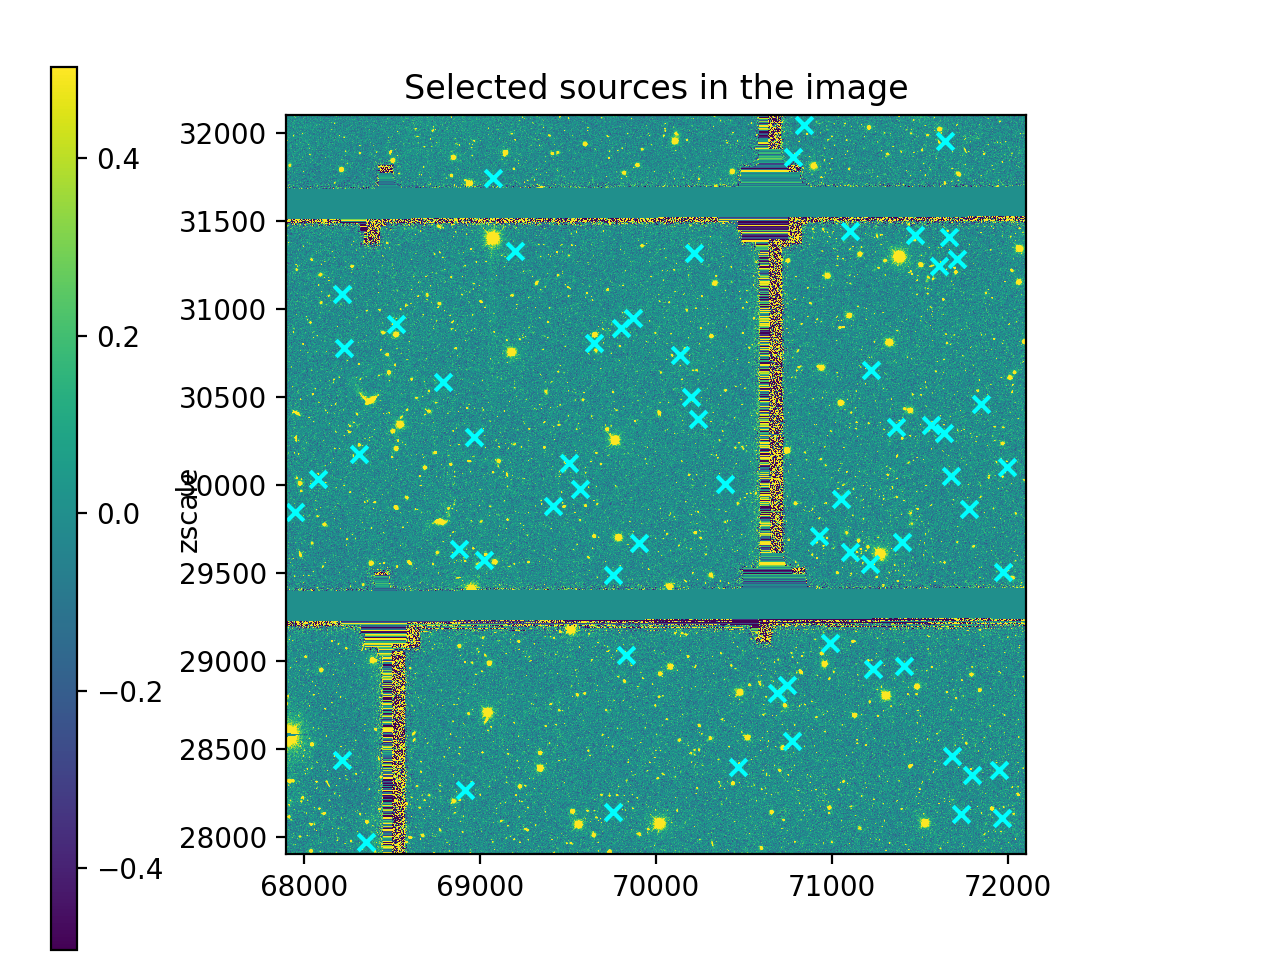

In [53]:
# Show the image with the centroids of the selected sources
zScaler = ZScaleInterval()
vmin, vmax = zScaler.get_limits(coaddexp.image.array)
bbox = coaddexp.getBBox()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cb = ax.imshow(coaddexp.image.array, origin='bottom', interpolation='none', vmin=vmin, vmax=vmax,
              extent=[bbox.getMinX()-0.5, bbox.getMaxX()+0.5, bbox.getMinY()-0.5, bbox.getMaxY()+0.5])
ax.scatter(goodSrc['base_SdssCentroid_x'], goodSrc['base_SdssCentroid_y'],
             marker='x', color='cyan')
ax.set_title("Selected sources in the image")
ax = fig.add_axes((0.04,0.01,0.02,0.92))
fig.colorbar(cb, cax=ax, label='zscale')

### Subtraction on one source

In [54]:
res = getCutoutAndPsf(coaddexp, goodSrc[10])

Image cutout

<IPython.core.display.Javascript object>


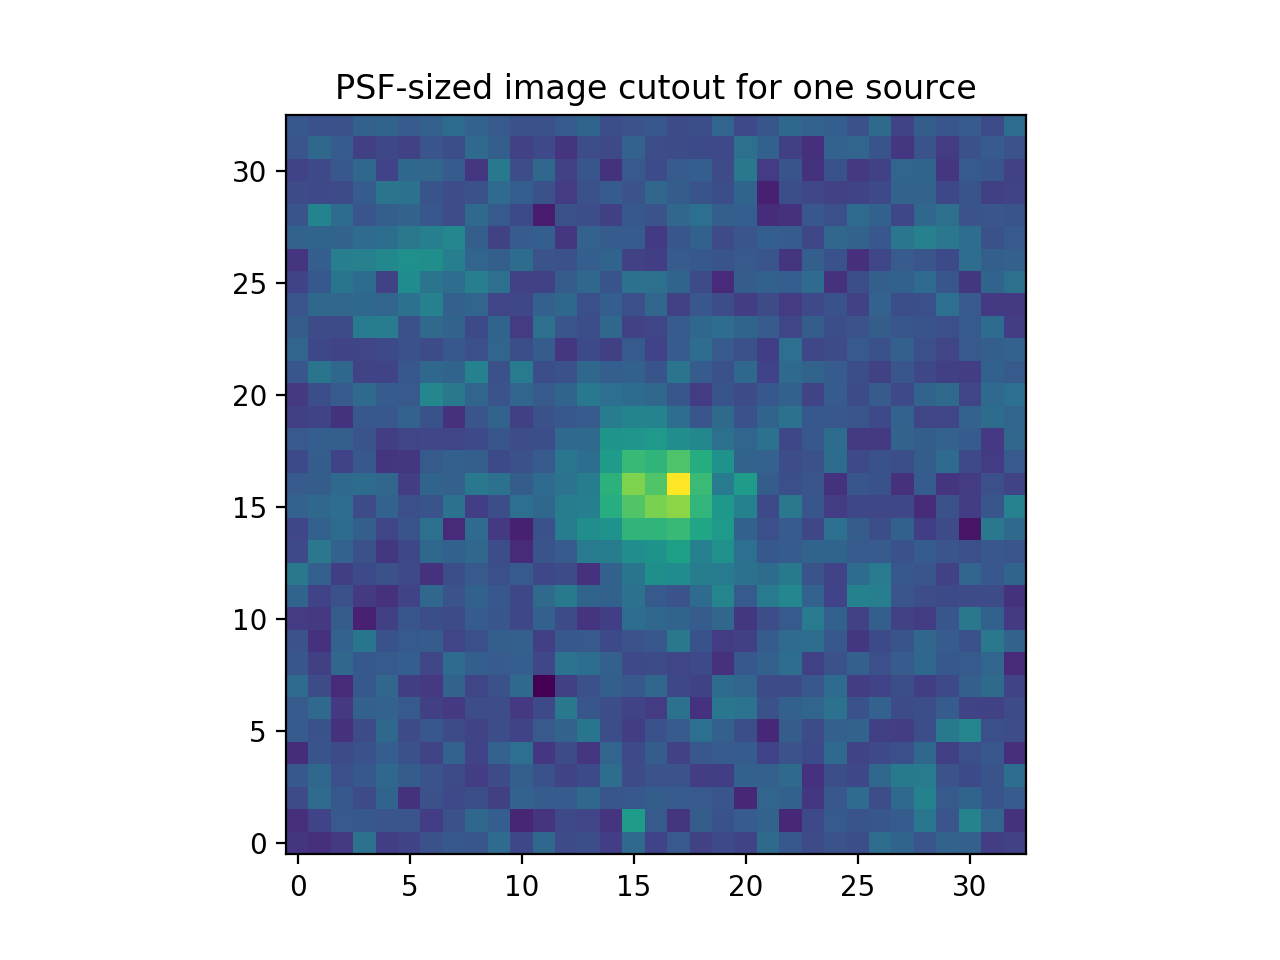

Text(0.5, 1.0, 'PSF-sized image cutout for one source')

In [55]:
# Source cutout of the calexp
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(res.cutExp.image.array, origin='bottom', interpolation='none')
ax.set_title("PSF-sized image cutout for one source")

In [56]:
# Test the minimization in this case
resD = minimizeDiff(res.cutExp, res.psfIm)

Residual image

<IPython.core.display.Javascript object>


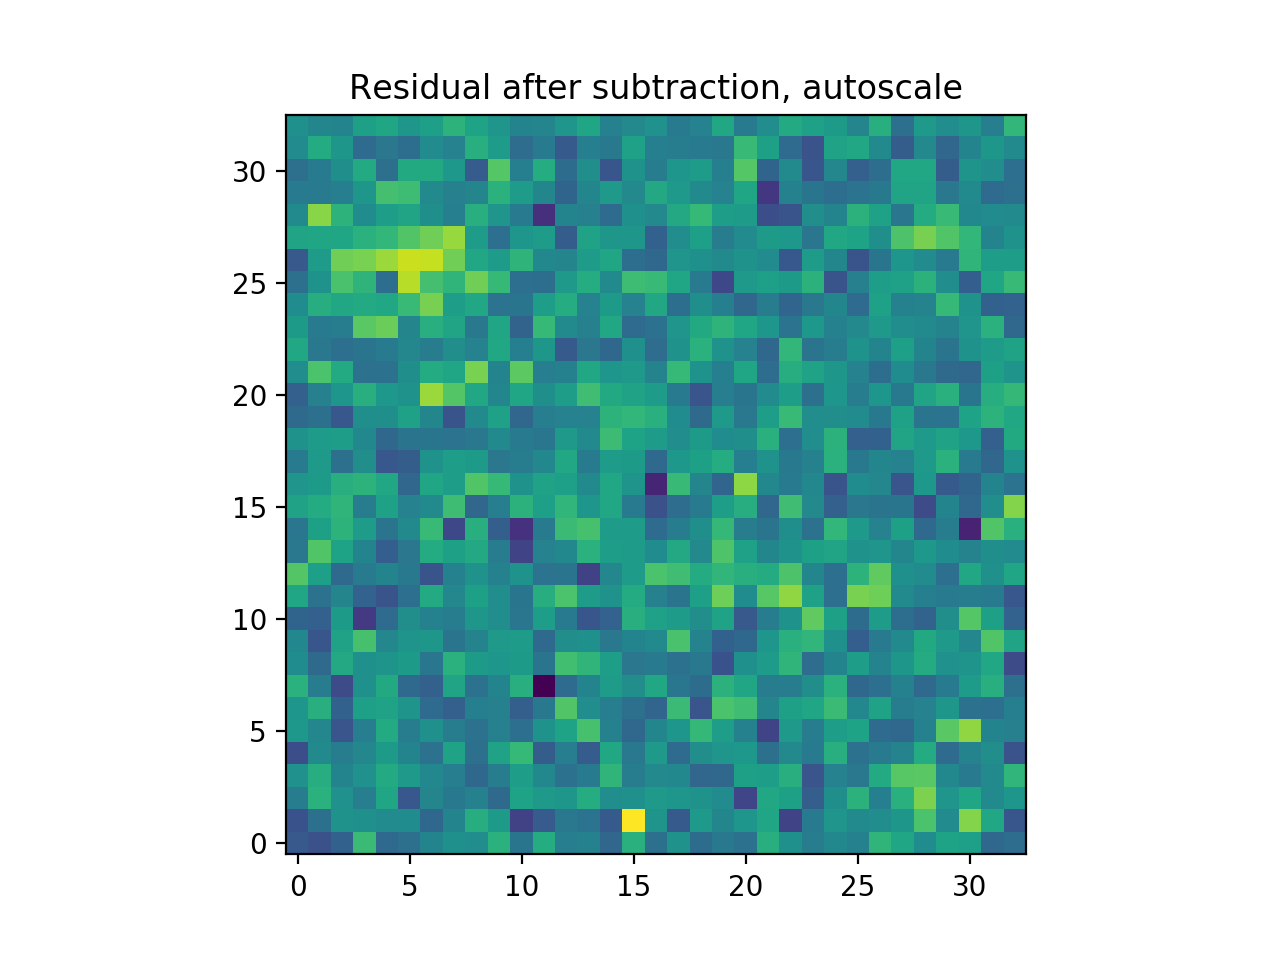

Text(0.5, 1.0, 'Residual after subtraction, autoscale')

In [57]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(resD.diffArr, origin='bottom', interpolation='none')
ax.set_title("Residual after subtraction, autoscale")

In [58]:
medianVar = np.median(coaddexp.variance.array)

-------

### Sanity check our minimization

If the two images are identical and differ only by a factor of 2 then the optimal solution
should be equal to 2.

In [59]:
%run -n -i "subtraction_defs.py"

In [60]:
im2 = res.cutExp.clone()
im2.image /= 2.
resD = minimizeDiff(res.cutExp, im2.image)

In [61]:
print(resD.x)

2.000000000000001


-------

### Loop through good sources
Simple subtraction by optimizing the PSF multiplicative factor only

<IPython.core.display.Javascript object>


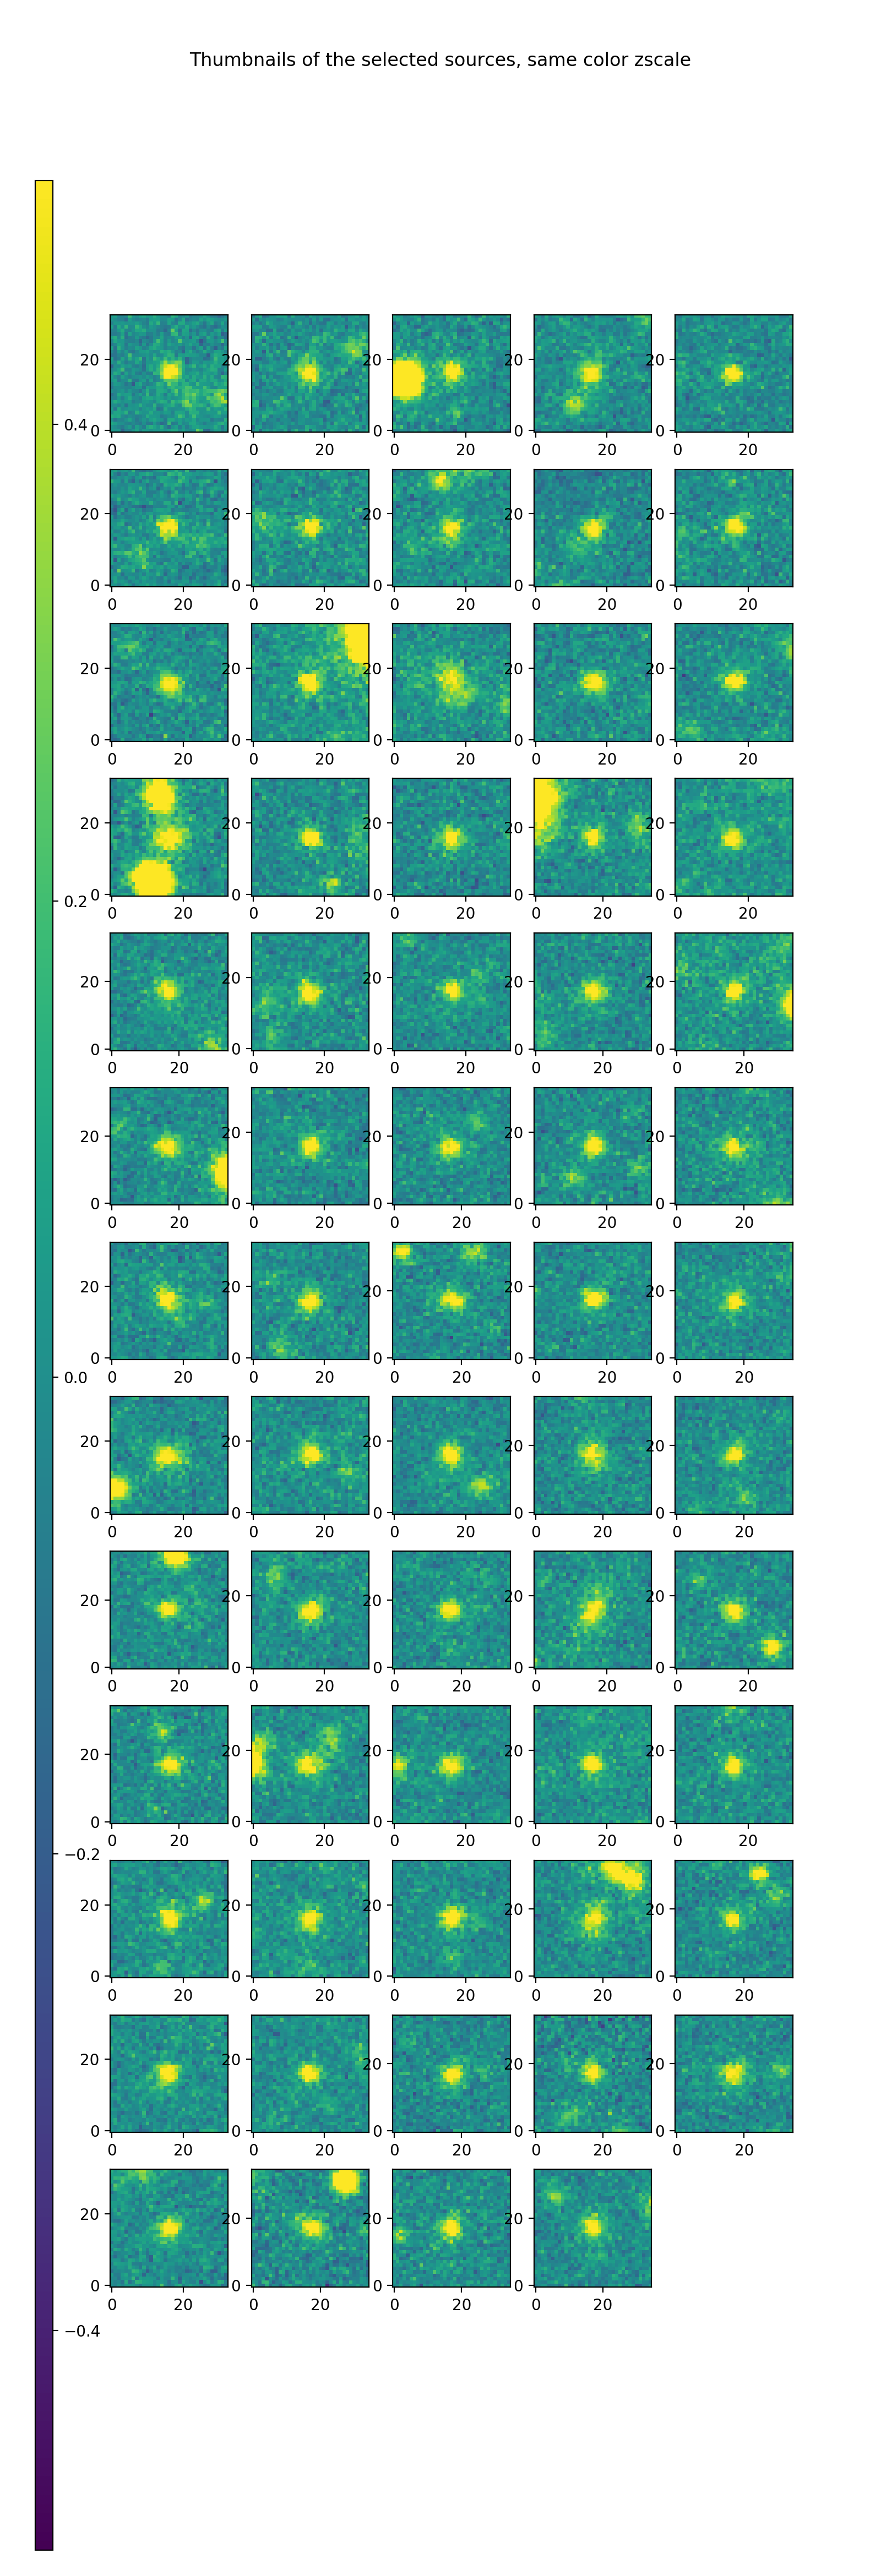

<IPython.core.display.Javascript object>


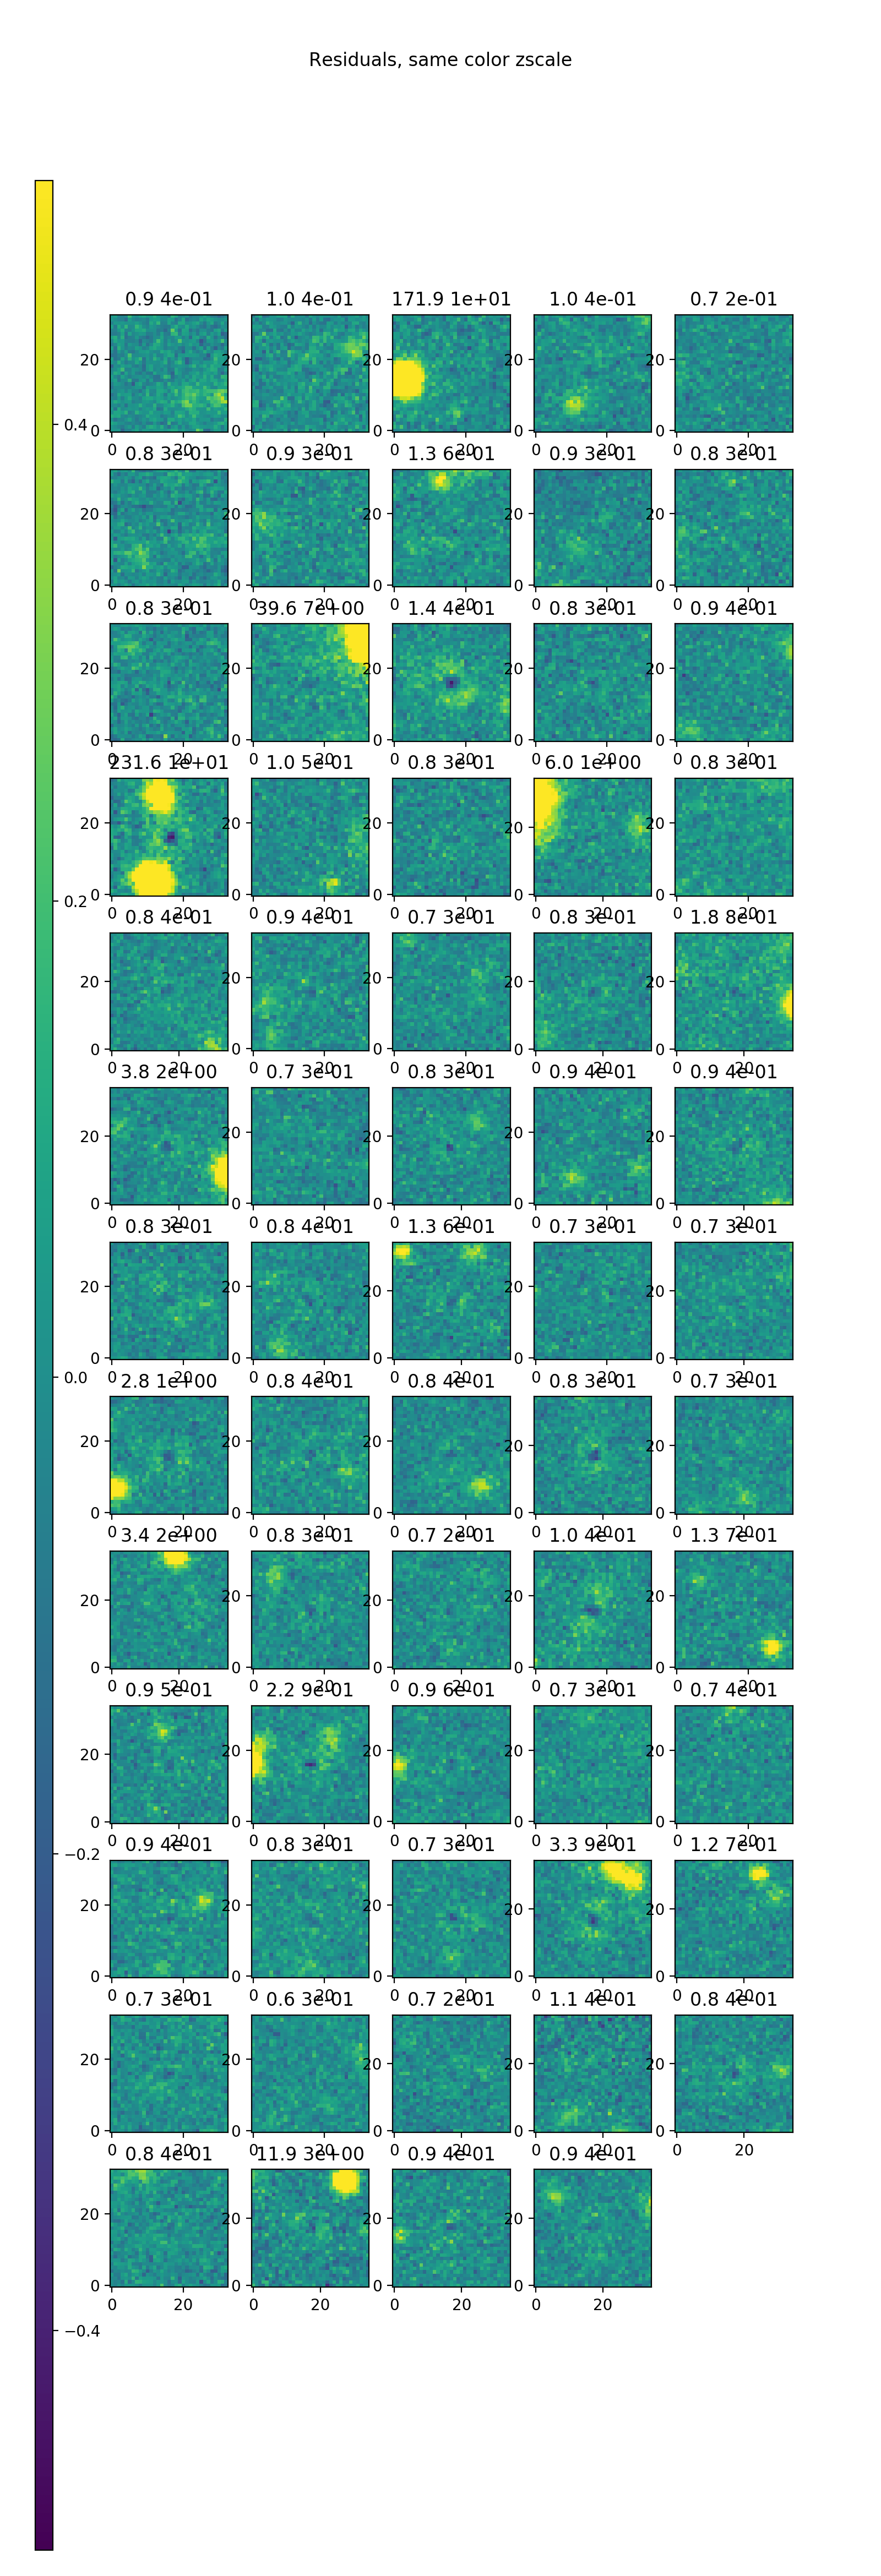

Text(0.5, 0.98, 'Residuals, same color zscale')

In [62]:
axPerRow = 5
nRows = len(goodSrc) // axPerRow + 1
fig_orig = plt.figure(figsize=(8, nRows*1.8))
fig = plt.figure(figsize=(8, nRows*1.8))

i_ax = 1
for src in goodSrc:
    res = getCutoutAndPsf(coaddexp, src)
    resD = minimizeDiff(res.cutExp, res.psfIm)
    chi2perDof = resD.chi2 / medianVar / resD.diffArr.size
    
    ax = fig.add_subplot(nRows, axPerRow, i_ax)
    ax_orig = fig_orig.add_subplot(nRows, axPerRow, i_ax)
    ax_orig.imshow(res.cutExp.image.array, origin='bottom', interpolation='none', 
                   vmin=vmin, vmax=vmax)
    A = resD.diffArr
    cb = ax.imshow(A, origin='bottom', interpolation='none', vmin=vmin, vmax=vmax)
    
    ax.set_title(f"{chi2perDof:.1f} {np.max(A):.0e}")
    i_ax += 1
ax = fig.add_axes((0.04,0.01,0.02,0.92))
fig.colorbar(cb, cax=ax)
ax = fig_orig.add_axes((0.04,0.01,0.02,0.92))
fig_orig.colorbar(cb, cax=ax)
fig_orig.suptitle("Thumbnails of the selected sources, same color zscale")
fig.suptitle("Residuals, same color zscale")

Top-left: residual chi2 per pixel. Top-right: maximum value of residual image.

 * For sources with apparent additional secondary source in the cutout (e.g. 3rd row 2nd col; last one) the residual minimization results in oversubtraction. The negative residual of the primary source can be seen in the center and a positive residual of the satellite source. Also this is reflected by the higher chi2 per dof value.



------